In [57]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
import glob

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 

%matplotlib inline

to get a good topo 
- make the uplift rate .01
- runtime is 5000 times with 100 yr timestep (500,000 years total)
- just a random non tilted basic elevation


In [58]:
#Set grid parameters
num_rows = 100
num_columns = 100
node_spacing = 10.00
node_next_to_outlet = num_columns + 1
outlet_node = 0 

#Set Model Time Parameters
timestep = 10.0
run_time = 10000 #years
uplift_rate = .01 # m/year
uplift_per_timestep = uplift_rate * timestep
#

mg = RasterModelGrid((num_rows, num_columns), node_spacing)#Instantiate model grid

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
mg.status_at_node[outlet_node] = mg.BC_NODE_IS_FIXED_VALUE

#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 0 #Set 2 m of initial soil depth at core nodes

np.random.seed(seed = 5000)#Set constant random seed for consistent topographic roughness

#Add field 'bedrock__elevation' to the grid mg.node_y
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"] += (np.random.rand(len(mg.node_y)) / 10) #cm scale rn 
mg.at_node['bedrock__elevation'][outlet_node] = 0 # do this before the mg.at node stuff above
#Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation' 
#when u change spacing high

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')
mg.at_node["topographic__elevation"][:] += mg.at_node["bedrock__elevation"]# + mg.at_node['soil__depth'][:]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]
#mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

#outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
#mg.at_node['bedrock__elevation'][outlet_node] = 1 # do this before the mg.at node stuff above
#outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)

mg.at_node['topographic__elevation'][outlet_node] = 0
mg.at_node['soil__depth'][outlet_node] = 0
print(outlet_node)

0


#Set grid parameters
num_rows = 100
num_columns = 100
node_spacing = 10.00
node_next_to_outlet = num_columns + 1
outlet_node = 0 

#Set Model Time Parameters
timestep = 50.0
run_time = 10000 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

mg = RasterModelGrid((num_rows, num_columns), node_spacing)#Instantiate model grid

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
mg.status_at_node[outlet_node] = mg.BC_NODE_IS_FIXED_VALUE

#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

np.random.seed(seed = 5000)#Set constant random seed for consistent topographic roughness
topo = mg.node_y/10
random_noise =  (np.random.rand(len(mg.node_y)) / 100) 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] += topo+random_noise #cm scale rn 
mg.at_node['bedrock__elevation'][outlet_node] = 0 # do this before the mg.at node stuff above
#Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation' 
#when u change spacing high

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')
mg.at_node["topographic__elevation"][:] += mg.at_node["bedrock__elevation"]# + mg.at_node['soil__depth'][:]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]
#mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

#outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
#mg.at_node['bedrock__elevation'][outlet_node] = 1 # do this before the mg.at node stuff above
#outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)

mg.at_node['topographic__elevation'][outlet_node] = 0
mg.at_node['soil__depth'][outlet_node] = 0
print(outlet_node)

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
#mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)


#Set grid parameters
num_rows = 100
num_columns = 100
node_spacing = 10.00
node_next_to_outlet = num_columns + 1
outlet_node = 0 

#Set Model Time Parameters
timestep = 100.0
run_time = 10000 #years
uplift_rate = .01 # m/year
uplift_per_timestep = uplift_rate * timestep

mg = RasterModelGrid((num_rows, num_columns), node_spacing)#Instantiate model grid

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
mg.status_at_node[outlet_node] = mg.BC_NODE_IS_FIXED_VALUE

(mg,_) = read_esri_ascii(r"C:\Users\gsbir\Documents\EES_393\Export\sample_topo2_bedrock__elevation.txt", name = "bedrock__elevation", grid = mg)
(mg,_) = read_esri_ascii(r"C:\Users\gsbir\Documents\EES_393\Export\sample_topo2_topographic__elevation.txt", name = "topographic__elevation", grid = mg)
(mg,_) = read_esri_ascii(r"C:\Users\gsbir\Documents\EES_393\Export\sample_topo2_soil__depth.txt", name = "soil__depth", grid = mg)

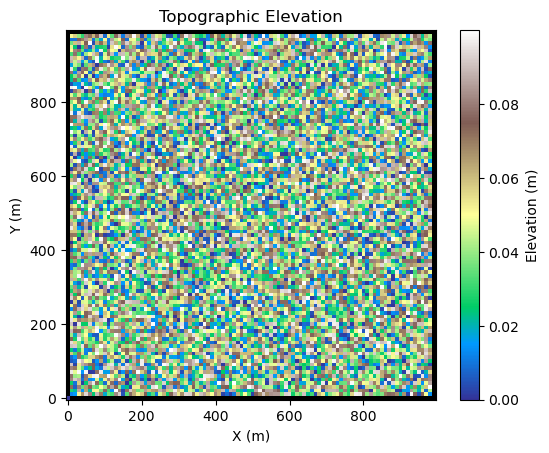

In [59]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


In [60]:
#Parameters for SPACE and Fastscape
K_sed = 0.0001
K_sp = 0.001
K_br = 0.0001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8') 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)

#Instantiate SPACE model with chosen parameters as sp
sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)# K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br 

expweath = ExponentialWeatherer(mg)
DDdiff = DepthDependentDiffuser(mg)

expweath.calc_soil_prod_rate()
np.allclose(mg.at_node['soil_production__rate'][mg.core_nodes], 1.)


True

TRY RUNNING AT 10 SPACING FOR 100000 

In [61]:

#run for 10 years
for x in range(5000): # at 10000 topo look doesn't change much
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
    #mg.at_node['topographic__elevation'][mg.core_nodes] = mg.at_node['bedrock__elevation'][mg.core_nodes] + mg.at_node['soil__depth'][mg.core_nodes]  #adding uplift to the bedrock
    #mg.at_node["topographic__elevation"][0] -= 0.001 # Uplift
    
    fa.run_one_step()
    #fr.run_one_step()    
    df.map_depressions()
       
    fsc.run_one_step(timestep)
    #DDdiff.run_one_step(1)
    print(x) 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

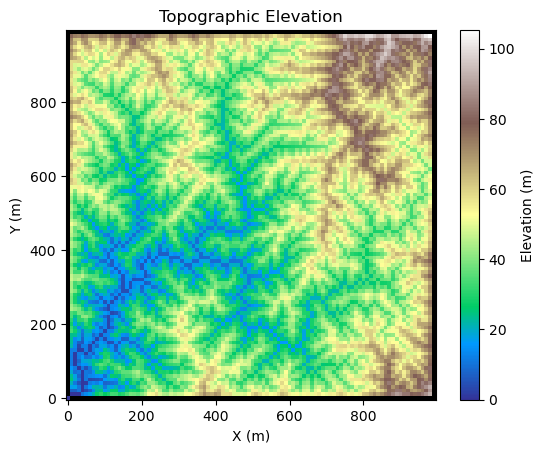

In [62]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


saving grid to ascii


In [63]:
grid_fields_to_save = ["topographic__elevation", "bedrock__elevation", "soil__depth"]

fname ="sample_topo2.txt"
# r"C:\Users\gsbir\Documents\EES_393"  + "\\Export\\" + 
write_esri_ascii(fname, mg, grid_fields_to_save)

['sample_topo2_topographic__elevation.txt',
 'sample_topo2_bedrock__elevation.txt',
 'sample_topo2_soil__depth.txt']

Running SPACE

In [64]:

space_years = np.arange(1,1000,10000)

#run for 10 years
for x in range(5): 
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'][mg.core_nodes]+= uplift_per_timestep  #adding uplift to the bedrock
    #mg.at_node["topographic__elevation"][0] -= 0.001 # Uplift
    
    fr.run_one_step()
    #fa.run_one_step()
    #df.map_depressions()
    sp.run_one_step(dt = timestep)
    #DDdiff.run_one_step(1)
    print(x) 



0
1
2
3
4


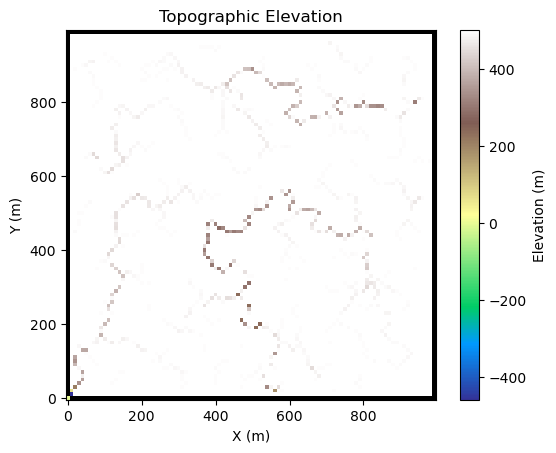

In [65]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


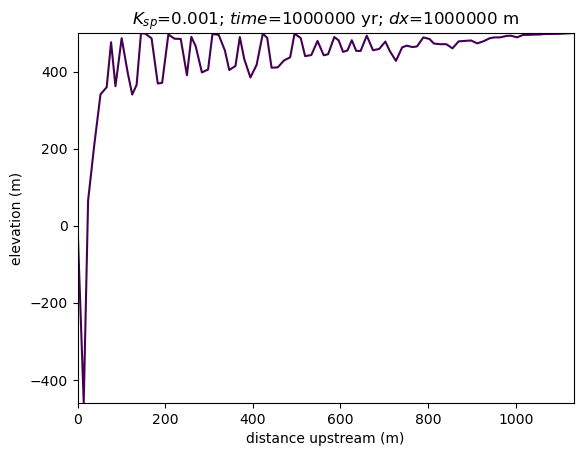

In [66]:
prf = ChannelProfiler(mg,
                      number_of_watersheds=1,
                      main_channel_only=True,
                      minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

#Show the profile
plt.figure(1)
title_text = f"$K_{{sp}}$={.001}; $time$={1000000} yr; $dx$={1000000} m"
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)', title=title_text)